In this notebook, we will implement the StarDist model for instance segmentation in Pytorch (mostly) from scratch. I will skip the introduction on how StarDist works, because this should step-by-step become apparent in this notebook. Readers who want to read up first are hereby referred to the original paper:
* Schmidt, Weigert, Broaddus, Myers: [Cell Detection with Star-convex Polygons](https://arxiv.org/abs/1806.03535). **2018**.

The original authors have provided source code for a TensorFlow implementation of their model at Github: 
* https://github.com/stardist/stardist

The purpose of this notebook is therefore purely educative. For this educative purpose, we will reimplement mostly all functionalities. The only function, we will directly use from the original implementation is the "\_edt_prob_scipy" function ([source](https://github.com/stardist/stardist/blob/master/stardist/utils.py)). In special, we will reimplement some functionalities in Python that are written in C++ in the original StarDist implementation. These functionalities might be a bit slower in Python, however this might provide a better understanding to readers not familiar with C++.

We will work with a dataset of microscope images of HeLa cells stably expressing H2b-GFP that has been publicized by the [Mitocheck consortium](https://www.mitocheck.org/) and can be found [here](http://celltrackingchallenge.net/2d-datasets/).

In [1]:
import matplotlib.pyplot as plt
from matplotlib.path import Path as mlp_Path
import numpy as np
from skimage import io
import urllib
import zipfile
import os
import ssl
from pathlib import Path
import random
import math
from itertools import product
import pandas as pd
import cv2
from numba import njit, prange 
import pyclipper
import albumentations as A
import torch
import torch.nn as nn
from torch.nn import (
    Conv2d, ReLU, Sigmoid, BatchNorm2d, MaxPool2d, Upsample)
from torch.utils.data import Dataset, DataLoader
from pytorch_lightning.callbacks import (
    ModelCheckpoint, EarlyStopping, LearningRateMonitor)
from pytorch_lightning.loggers import CSVLogger
import torch.nn.functional as F
import pytorch_lightning as pl
from torchinfo import summary
from extra.schedulers import MultiplicativeDecayWithReduceOrRestartOnPlateau
import torch.onnx
import onnxruntime
# Find code for _edt_prob_scipy here: https://github.com/stardist/stardist/blob/master/stardist/utils.py
from stardist.utils import _edt_prob_scipy
import logging
logging.getLogger("pytorch_lightning").setLevel(logging.WARNING)

random.seed(42)
torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

C:\Users\User\anaconda3\envs\CNN007-torch\lib\site-packages\pkg_resources\__init__.py:123: PkgResourcesDeprecationWarning: win32 is an invalid version and will not be supported in a future release
  warnings.warn(


cpu


Let's set some hyperparameters. The original image size is 700x1100 pixels. Because we will use a U-net as a backbone model for StarDist and this encompasses max pooling layers (=/ 2), this is a rather inconvenient image size and we will therefore resize to 704x1088 pixels. Subsequently, we will create patches of 352x272 pixels from these and use these to ease memory requirements. Two other hyperparameters related to StarDist are *N*=32, defining the number of radial directions in that the star-convex polygon that the StarDist model ultimatively predicts. *deepth*, *filter_init*, and *etra_feats* are hyperparameters related to the U-net backbone of StarDist. Because the StarDist model predicts both an object probability as well as radial distances, we will later on define a custom loss function that combines a cross-entropy term as well as a mean absolute error term for this. The *l1_weight* hyperparameter defines the weight of the mean absolute error term in this sum. *prob_thresh* / *nms_threshold* hyperparameters are related to the non-max suppression of StarDist. The other hyperparameters here are mostly related to a custom learning rate scheduler that is mostly over the top for this notebook but is used here out of convience reasons anyhow.

In [2]:
img_resized_shape = (1, 704, 1088)
patch_shape = (1, 352, 272) 
N = 32 # number of radials
l1_weight = 10 # weight of MAE loss in custom stardist loss
prob_thresh = 0.5
nms_threshold = 0.4
deepth = 3
filter_init = 16
extra_feats = 64

epochs = 40
batch_size = 16
patience_early_stopping = 12

lr_init = 8e-4
lr_decay = 0.98
lr_max = lr_init * 2
f_reduction = 0.25
f_restart = 1.25
patience = 4
min_loss_improvement = 0.001
no_of_restarts_init = 1
increment_no_of_restarts = 1

Let's download the dataset, get the corresponding file paths, and have a first peak how the data looks like:

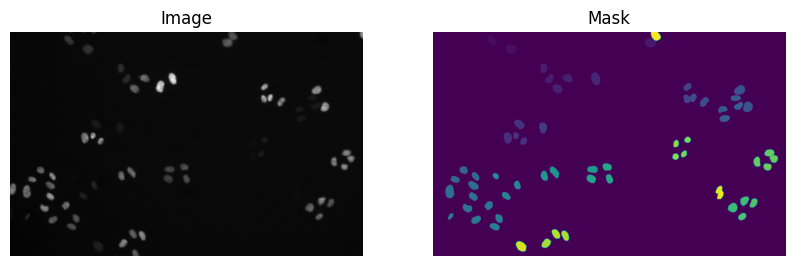

In [3]:
# HeLa cells stably expressing H2b-GFP
# http://celltrackingchallenge.net/2d-datasets/

ssl._create_default_https_context = ssl._create_unverified_context
url = "http://data.celltrackingchallenge.net/training-datasets/Fluo-N2DL-HeLa.zip"
data_dir = ".//data"

zip_path, _ = urllib.request.urlretrieve(url)
with zipfile.ZipFile(zip_path, "r") as f:
    f.extractall(data_dir)

dir_imgs_orig = data_dir + "//Fluo-N2DL-HeLa//01//"
fps_imgs_orig = [dir_imgs_orig+x for x in next(os.walk(dir_imgs_orig))[2]]

fp_masks_orig = data_dir + "//Fluo-N2DL-HeLa//01_ST//SEG//"
fps_masks_orig = [fp_masks_orig+x for x in next(os.walk(fp_masks_orig))[2]]

idx0 = 20
img1 = io.imread(fps_imgs_orig[idx0])
mask1 = io.imread(fps_masks_orig[idx0])

fig, ax = plt.subplots(1,2, figsize=(10, 8))
ax[0].imshow(img1, cmap="gray")
ax[0].set_title("Image")
ax[1].imshow(mask1)
ax[1].set_title("Mask")
[axi.set_axis_off() for axi in ax.ravel()]
plt.show()

Now we will resize the images and convert the instance segmented masks provided with the dataset to the custom masks necessary for training StarDist. These customs masks entail:
* One mask of object probabilities. For each pixel the probability of this pixel belonging to an object and not the background is calculated using the "\_edt_prob_scipy" function. The calculation is based on a distance transform.
* N (=32 here) masks that define for each pixel the distance to the next pixel not belonging to the same instance class in a certain radial direction. We will reimplement the function to create these masks here. The original StarDist implementation features a Python implementation for this as well (["_py_star_dist"](https://github.com/stardist/stardist/blob/master/stardist/geometry/geom2d.py)). However, this implementation is rather slow. We will use [numba](https://numba.pydata.org/) to speed this up.

If the nature of the StarDist masks has not become clear to you yet, just scroll to some visuals examples that can be found two code cells below:

In [4]:
dir_imgs = "./data/imgs/"
dir_masks = "./data/masks/"
dir_masks_stardist = "./data/masks_stardist/"

[os.makedirs(x, exist_ok=True) for x in [
    dir_imgs, dir_masks, dir_masks_stardist]]


@njit()
def star_dist_sub(img, combs, N):
    dst = np.zeros(img.shape + (N,))
    
    for idx in prange(combs.shape[0]): 
        i, c, j, dx, dy = combs[idx]
        val = img[np.int32(i), np.int32(j)]
        if val != 0:
            x, y = np.float32(0), np.float32(0)
            while True:
                x = x + dx
                y = y + dy
                ii = np.int32(np.round(i+x))
                jj = np.int32(np.round(j+y))
                if ((ii < 0) or (ii >= img1.shape[0]) or (jj < 0) or 
                    (jj >= img.shape[1]) or (val != img[ii,jj])):
                    t_corr = 1 - 0.5 / max(np.abs(dx), np.abs(dy))
                    x = x - t_corr * dx
                    y = y - t_corr * dy
                    dist = np.sqrt(x**2 + y**2)
                    dst[np.int32(i), np.int32(j), np.int32(c)] = dist
                    break
    return dst
    

def star_dist_main(img, N):
    combs = np.transpose(np.array(np.meshgrid(
        np.arange(img.shape[0]),
        np.arange(N),
        np.arange(img.shape[1]))).reshape(3, -1))
    
    combs = np.concatenate((
        combs, 
        np.expand_dims(np.sin(2 * np.pi * combs[:, 1] / N), 1),
        np.expand_dims(np.cos(2 * np.pi * combs[:, 1] / N), 1)), axis=1)
    return star_dist_sub(img, combs, N)


max_val_dists = 0
for fp_img, fp_mask in zip(fps_imgs_orig, fps_masks_orig):
    img = io.imread(fp_img).astype(np.float32)
    mask = io.imread(fp_mask).astype(np.float32)
   
    img = (img - np.min(img)) / (np.max(img) - np.min(img))
    transform = A.Compose([
        A.Resize(img_resized_shape[1], img_resized_shape[2], 
                  interpolation=cv2.INTER_NEAREST, p=1.0)])
    transformed = transform(image=img, mask=mask)
    img = transformed["image"]
    mask = transformed["mask"]
    
    mask_dists = star_dist_main(mask, N=N)
    if np.max(mask_dists) > max_val_dists:
        max_val_dists = np.max(mask_dists)
    mask_probs = np.expand_dims(
        _edt_prob_scipy(mask.astype(np.int32)), 2)
    mask_stardist = np.concatenate((mask_dists, mask_probs), axis=2)
   
    np.save(dir_imgs + fp_img.split("/")[-1][:-4] + ".npy", 
            np.expand_dims(img, 2))
    np.save(dir_masks + fp_img.split("/")[-1][:-4] + ".npy", 
            np.expand_dims(mask, 2))
    np.save(dir_masks_stardist + fp_img.split("/")[-1][:-4] + ".npy", 
            mask_stardist)

Now we will split the data into training, validation and test data and slice the images/masks into smaller patches that are more convenient to work with:

In [5]:
def split_data(fns, train_ratio, val_ratio):
    test_ratio = 1 - train_ratio - val_ratio
    no_train_samples = int(len(fns) * train_ratio)
    no_test_samples =  int(len(fns) * test_ratio)
    
    idx_train = random.sample(range(len(fns)), no_train_samples)
    idx_val = [x for x in range(len(fns)) if x not in idx_train]
    idx_test = random.sample(idx_val, no_test_samples)
    idx_val = [x for x in idx_val if x not in idx_test]
    
    fns_train = [fns[x] for x in idx_train]
    fns_val = [fns[x] for x in idx_val]
    fns_test = [fns[x] for x in idx_test]   
    return fns_train, fns_val, fns_test


fns_imgs = [x for x in next(os.walk(dir_imgs))[2]]
fns_train, fns_val, fns_test = split_data(fns_imgs, 0.6, 0.2)


dir_train_imgs = "./data/train_imgs/"
dir_train_masks = "./data/train_masks/"
dir_train_masks_stardist = "./data/train_masks_stardist/"

dir_val_imgs = "./data/val_imgs/"
dir_val_masks = "./data/val_masks/"
dir_val_masks_stardist = "./data/val_masks_stardist/"

dir_test_imgs = "./data/test_imgs/"
dir_test_masks = "./data/test_masks/"
dir_test_masks_stardist = "./data/test_masks_stardist/"

[os.makedirs(x, exist_ok=True) for x in [
    dir_train_imgs, dir_train_masks, dir_train_masks_stardist,
    dir_val_imgs, dir_val_masks, dir_val_masks_stardist, 
    dir_test_imgs, dir_test_masks, dir_test_masks_stardist]]

         
def patchify(dir_in, fn_in, dir_out, patch_shape):
    for idx, fp in enumerate([dir_in+x for x in fn_in]):
        img = np.load(fp)
        no_patches_y = int(
            ((img.shape[1] - patch_shape[2]) / patch_shape[2]) + 1)
        no_patches_x = int(
            ((img.shape[0] - patch_shape[1]) / patch_shape[1]) + 1)
        
        for idx0, (idx1, idx2) in enumerate(
                product(range(no_patches_x), range(no_patches_y))):
           
            temp = img[(idx1 * patch_shape[1]):((idx1+1) * patch_shape[1]),
                        (idx2 * patch_shape[2]):((idx2+1) * patch_shape[2])]
            np.save(
                dir_out + fn_in[idx][:-4] + f"_patch{str(idx0).zfill(3)}.npy", temp)
   
    
patchify(dir_imgs, fns_train, dir_train_imgs, patch_shape)
patchify(dir_masks, fns_train, dir_train_masks, patch_shape)
patchify(dir_masks_stardist, fns_train, dir_train_masks_stardist, patch_shape)

patchify(dir_imgs, fns_val, dir_val_imgs, patch_shape)
patchify(dir_masks, fns_val, dir_val_masks, patch_shape)
patchify(dir_masks_stardist, fns_val, dir_val_masks_stardist, patch_shape)

patchify(dir_imgs, fns_test, dir_test_imgs, patch_shape)
patchify(dir_masks, fns_test, dir_test_masks, patch_shape)
patchify(dir_masks_stardist, fns_test, dir_test_masks_stardist, patch_shape)

fps_train_imgs = [dir_train_imgs+x for x in next(os.walk(dir_train_imgs))[2]]


fps_train_masks = [dir_train_masks+x for x in next(os.walk(
    dir_train_masks))[2]]
fps_train_masks_stardist = [dir_train_masks_stardist+x for x in next(
    os.walk(dir_train_masks_stardist))[2]]

fps_val_imgs = [dir_val_imgs+x for x in next(os.walk(dir_val_imgs))[2]]
fps_val_masks = [dir_val_masks+x for x in next(os.walk(dir_val_masks))[2]]
fps_val_masks_stardist = [dir_val_masks_stardist+x for x in next(
    os.walk(dir_val_masks_stardist))[2]]

fps_test_imgs = [dir_test_imgs+x for x in next(os.walk(
    dir_test_imgs))[2]]
fps_test_masks = [dir_test_masks+x for x in next(os.walk(
    dir_test_masks))[2]]
fps_test_masks_stardist = [dir_test_masks_stardist+x for x in next(
    os.walk(dir_test_masks_stardist))[2]]

Next, we define the Pytorch dataset and datloaders:

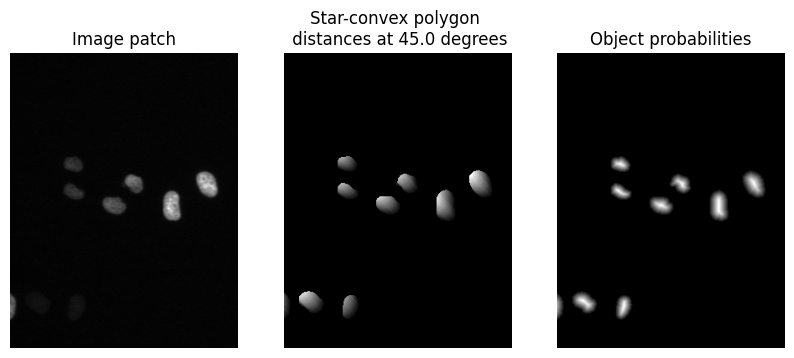

In [6]:
class CustomDataset(Dataset):
    def __init__(self, fps_imgs, fps_masks, max_val_mask, N, augment=False):
        self.fps_imgs = fps_imgs
        self.fps_masks = fps_masks
        self.max_val_mask = max_val_mask
        self.N = N
        self.augment = augment

    def __len__(self):
        return len(self.fps_imgs)

    def __getitem__(self, idx):
        fp_img = self.fps_imgs[idx]
        fp_mask = self.fps_masks[idx]
        
        img = np.load(fp_img)
        mask = np.load(fp_mask)       
        mask[:, :, 0:self.N] = mask[:, :, 0:self.N] / self.max_val_mask

        if self.augment:
            transform = A.Compose([
                A.ColorJitter(p=0.3)])
            
            transformed = transform(image=img, mask=mask)
            img = transformed["image"]
            mask = transformed["mask"]
           
        img = torch.tensor(np.moveaxis(img, 2, 0)).float()
        mask = torch.tensor(np.moveaxis(mask, 2, 0)).float()
        return img, mask

# max_val_dists = 54.5 # XXX
ds_train = CustomDataset(
    fps_train_imgs, fps_train_masks_stardist, max_val_dists, N, 
    augment=True)
ds_val = CustomDataset(
    fps_val_imgs, fps_val_masks_stardist, max_val_dists, N)
ds_test = CustomDataset(
    fps_train_masks_stardist, fps_test_masks_stardist, max_val_dists, N)

idx1 = 25
idx2 = 4

fig, ax = plt.subplots(1, 3, figsize=(10, 8))
img2, mask2 = ds_train[idx1]
ax[0].imshow(img2.numpy()[0], cmap="gray")
ax[0].set_title("Image patch")
ax[1].imshow(mask2.numpy()[idx2], cmap="gray")
ax[1].set_title(f"Star-convex polygon \n distances at {idx2*360/N} degrees")
ax[2].imshow(mask2.numpy()[-1], cmap="gray")
ax[2].set_title("Object probabilities")
[axi.set_axis_off() for axi in ax.ravel()]
plt.show()

loader_train = DataLoader(ds_train, batch_size=batch_size, shuffle=True)
loader_val = DataLoader(ds_val, batch_size=batch_size, shuffle=False)

U-net builds the backbone of StarDist, so let's define that:

In [7]:
class UNetBlock(nn.Module):
    def __init__(self, filters_in, filters_out, contract=False, expand=False):
        super().__init__()
        self.conv1 = Conv2d(
            in_channels=filters_in, out_channels=filters_out, 
            kernel_size=3, stride=1, padding=1)
        self.conv2 = Conv2d(
            in_channels=filters_out, out_channels=filters_out, 
            kernel_size=3, stride=1, padding=1)
        self.activation = ReLU()
        self.bn1 = BatchNorm2d(filters_out)
        self.bn2 = BatchNorm2d(filters_out)
        
        self.upsample = Upsample(scale_factor=2, mode="bilinear")
        self.pooling = MaxPool2d((2, 2))
        
        self.contract = contract
        self.expand = expand
   
    def forward(self, x, x_skip=None):
        if self.expand:
            x = self.upsample(x)
            x = torch.cat([x, x_skip], dim=1)
            
        x = self.conv1(x)
        x = self.activation(x)
        x = self.bn1(x)
        
        x = self.conv2(x)
        x = self.activation(x)
        x = self.bn2(x)
    
        if self.contract:
            return self.pooling(x), x
        else:
            return x

        
class UNet(nn.Module):
    def __init__(self, contractions, filter_init, input_shape):
        super().__init__()
        assert (math.log2(filter_init).is_integer()), "log2(filter_init) must be an integer and > 0"
        assert (math.log2(filter_init) > 0), "log2(filter_init) must be an integer and > 0"
        assert (all([False for y in [(input_shape[1] / x) % 2 for x in [2**x for x in range(1, contractions)]] if y != 0])
                ), "Each contraction halves your input_shape[1]. In some step this causes an uneven number. Choose a different input size or less contractions"
        assert (all([False for y in [(input_shape[2] / x) % 2 for x in [2**x for x in range(1, contractions)]] if y != 0])
                ), "Each contraction halves your input_shape[2]. In some step this causes an uneven number. Choose a different input size or less contractions"
        
        self.contractions = contractions
        self.blocks = contractions * 2 + 1
        
        factors = [2**x for x in range(math.ceil(self.blocks / 2))]
        factors.extend(factors[::-1][1:])
        self.filters = [filter_init*x for x in factors]
        self.filters.insert(0, input_shape[0])

        self.layers = nn.ModuleList()
        for idx, cur_filter in enumerate(self.filters[:-1]):
            if idx in range(contractions):
                self.layers.append(UNetBlock(
                    self.filters[idx], self.filters[idx+1], contract=True))
            elif idx == contractions:               
                self.layers.append(UNetBlock(
                    self.filters[idx], self.filters[idx+1]))
            else:
                self.layers.append(
                    UNetBlock(self.filters[idx] + self.filters[idx+1], 
                              self.filters[idx+1], expand=True))

    def forward(self, x):
        x_skips = []
        for idx, cur_filter in enumerate(self.filters[:-1]):
            if idx in range(self.contractions):
                x, x_skip = self.layers[idx](x)
                x_skips.append(x_skip)
            elif idx == self.contractions:      
                x = self.layers[idx](x)
            else:
                x = self.layers[idx](
                    x, x_skips[-(idx - math.floor(self.blocks/2))])       
        return x

Furthmore, let's define our custom loss function:

In [8]:
class MixedLoss(nn.Module):
    def __init__(self, l1_weight):
        super(MixedLoss, self).__init__()
        self.l1_weight = l1_weight
        
    def forward(self, y_pred, y_true):
        y_pred_dists = y_pred[0]
        y_pred_probs = y_pred[1]
        
        y_true_dists = y_true[:, 0:-1, :, :]
        y_true_probs = y_true[:, -1:, :, :]
        
        l1_loss = torch.mean(F.l1_loss(
            y_pred_dists, y_true_dists, reduction="none") * y_true_probs)
        bce_loss = F.binary_cross_entropy(
            y_pred_probs, y_true_probs, reduction="mean")
        
        return l1_loss * self.l1_weight + bce_loss

Next, we define our complete StarDist model as a Pytorch Lightning model and define some callbacks:

In [9]:
cb1 = ModelCheckpoint(monitor="val_loss", mode="min")
cb2 = EarlyStopping(
    monitor="val_loss", mode="min", patience=patience_early_stopping)
cb3 = LearningRateMonitor(logging_interval="epoch")
logger = CSVLogger(save_dir="logs/", name="model", flush_logs_every_n_steps=1)


class StarDist(pl.LightningModule):
    def __init__(self, deepth, filter_init, input_shape, extra_feats, l1_weight):
        super().__init__()
        self.automatic_optimization = False
        self.unet = UNet(deepth, filter_init, input_shape)
        self.extra_feats = Conv2d(
            in_channels=self.unet.filters[-1], 
            out_channels=extra_feats, kernel_size=3, stride=1, padding=1)
        self.probs = Conv2d(
            in_channels=extra_feats, 
            out_channels=1, kernel_size=3, stride=1, padding=1)
        self.dists = Conv2d(
            in_channels=extra_feats, 
            out_channels=N, kernel_size=3, stride=1, padding=1)
        self.relu = ReLU()
        self.sigmoid = Sigmoid() 
        self.loss = MixedLoss(l1_weight=l1_weight)
        
    def forward(self, x):
        x = self.unet(x)
        x = self.extra_feats(x)
        x = self.relu(x)
        
        dists = self.dists(x)
        probs = self.probs(x)
        probs = self.sigmoid(probs)
        return [dists, probs]
    
    def training_step(self, batch, batch_idx):
        opt = self.optimizers()
        opt.zero_grad()
        x, y = batch[0], batch[1]
        y_pred = self.forward(x)
        loss = self.loss(y_pred, y)
        
        # For logging loss & metrics
        self.log("train_loss", loss, on_step=False, on_epoch=True, 
                 prog_bar=True)
        self.manual_backward(loss)
        opt.step()
        return loss
        
    def validation_step(self, batch, batch_idx):
        x, y = batch[0], batch[1]
        y_pred = self.forward(x)
        loss = self.loss(y_pred, y)
        
        # For logging loss & metrics
        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        if batch_idx == 0:
            self.cur_val_loss = []    
        self.cur_val_loss.append(loss)
        return loss
    
    def on_validation_epoch_end(self):
        # Take care of non-default scheduler
        self.cur_val_loss = torch.stack(self.cur_val_loss).mean()
        self.scheduler.step(self.cur_val_loss)
              
    def predict_step(self, batch, batch_idx):
        if isinstance(batch, list): # Dataloaders that return both X and y
            return self(batch[0]), batch[1]
        else: # Dataloaders that return only y
            return self(batch)
    
    def configure_optimizers(self):
        opt = torch.optim.Adam(self.parameters(), lr=lr_init)
        self.scheduler = MultiplicativeDecayWithReduceOrRestartOnPlateau(
            optimizer=opt, lr_init=lr_init, lr_decay=lr_decay, 
            lr_max=lr_max, f_reduction=f_reduction, f_restart=f_restart, 
            patience=patience, min_loss_improvement=min_loss_improvement, 
            no_of_restarts_init=no_of_restarts_init, 
            increment_no_of_restarts=increment_no_of_restarts)
        return opt


stardist = StarDist(deepth=deepth, filter_init=filter_init, input_shape=patch_shape, 
                    extra_feats=extra_feats, l1_weight=l1_weight)
summary(stardist.to(device), (1, 1, 352, 272), depth=5)

torchinfo.py (477): TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
storage.py (665): TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()


Layer (type:depth-idx)                   Output Shape              Param #
StarDist                                 [1, 32, 352, 272]         --
├─UNet: 1-1                              [1, 16, 352, 272]         --
│    └─ModuleList: 2-1                   --                        --
│    │    └─UNetBlock: 3-1               [1, 16, 176, 136]         --
│    │    │    └─Conv2d: 4-1             [1, 16, 352, 272]         160
│    │    │    └─ReLU: 4-2               [1, 16, 352, 272]         --
│    │    │    └─BatchNorm2d: 4-3        [1, 16, 352, 272]         32
│    │    │    └─Conv2d: 4-4             [1, 16, 352, 272]         2,320
│    │    │    └─ReLU: 4-5               [1, 16, 352, 272]         --
│    │    │    └─BatchNorm2d: 4-6        [1, 16, 352, 272]         32
│    │    │    └─MaxPool2d: 4-7          [1, 16, 176, 136]         --
│    │    └─UNetBlock: 3-2               [1, 32, 88, 68]           --
│    │    │    └─Conv2d: 4-8             [1, 32, 176, 136]         4,640
│    │  

Finally, we are ready to train. We will keep training rather short. For that reason, we might lose out some performance but keep training time reasonable (as I am not training on a GPU here):

In [10]:
trainer1 = pl.Trainer(
    max_epochs=epochs, check_val_every_n_epoch=1, profiler="simple",
    callbacks=[cb1, cb2, cb3], logger=logger, accelerator="cpu", 
    devices=1, enable_progress_bar=False)

trainer1.fit(
    model=stardist, train_dataloaders=loader_train, val_dataloaders=loader_val)

__init__.py (123): win32 is an invalid version and will not be supported in a future release
Missing logger folder: logs/model
data_connector.py (430): The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
data_connector.py (430): The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
fit_loop.py (280): The number of training batches (28) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


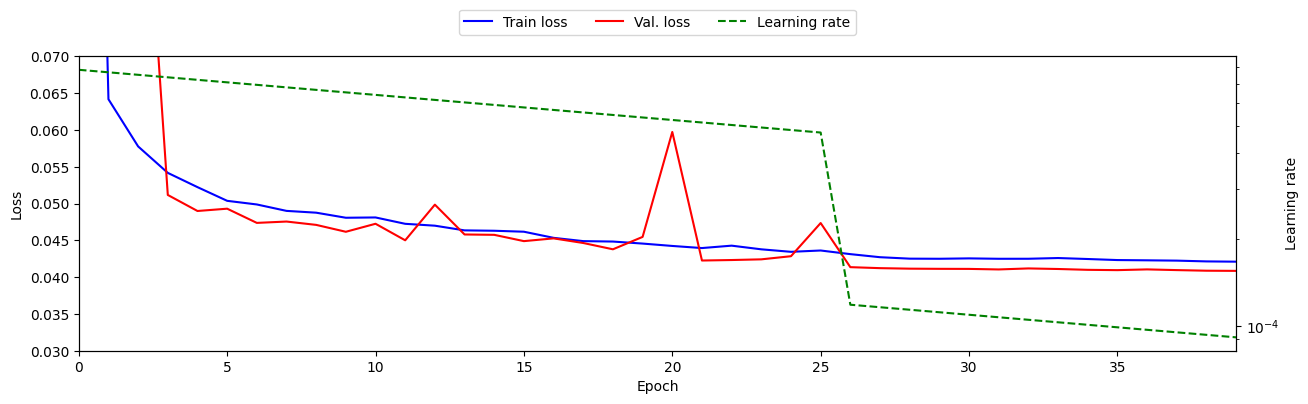

In [11]:
logs = pd.read_csv(Path(trainer1.logger.log_dir + "/metrics.csv"))
epochs = logs.dropna(subset=["train_loss"])["epoch"]

fig1, ax1 = plt.subplots(1, 1, figsize=(14, 5))
l1 = ax1.plot(
    epochs, logs["train_loss"].dropna(), color="b", label="Train loss")
l2 = ax1.plot(
    epochs, logs["val_loss"].dropna(), color="r", label="Val. loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.set_xlim(0, len(epochs)-1)
ax1.set_ylim(0.03, 0.07)
ax2 = ax1.twinx() 
l3 = ax2.plot(
    epochs, logs["lr-Adam"].dropna(), color="g", linestyle="dashed", 
    label="Learning rate")
ax2.set_ylabel("Learning rate")
ax2.set_yscale("log")
ax1.legend(l1+l2+l3, [l.get_label() for l in l1+l2+l3], loc="lower center", 
           bbox_to_anchor=(0, 1.05, 1, 0.2), ncol=3)
plt.tight_layout(pad=4)
plt.show()

We will reload our best model from checkpoint and export this model to [ONNX format](https://en.wikipedia.org/wiki/Open_Neural_Network_Exchange) so that the we can from now on use the model to predict independently of Pytorch:

In [12]:
checkpoint_file = trainer1.checkpoint_callback.best_model_path
stardist = stardist.load_from_checkpoint(
    checkpoint_file, deepth=3, filter_init=16, input_shape=patch_shape,
    extra_feats=64, l1_weight=l1_weight)

idx3 = 39
img_test = np.expand_dims(np.moveaxis(np.load(fps_test_imgs[idx3]), 2, 0), 0)
mask_test = np.expand_dims(np.moveaxis(np.load(
    fps_test_masks_stardist[idx3]), 2, 0), 0)
img_dummy = torch.zeros_like(torch.tensor(img_test))

torch.onnx.export(
    model=stardist, args=img_dummy, f="onnx_model.onnx", export_params=True,
    opset_version=13, do_constant_folding=True, input_names = ["input"], 
    output_names = ["output"], dynamic_axes={"input": {0 : "batch_size"}, 
                                             "output": {0 : "batch_size"}})

================ Diagnostic Run torch.onnx.export version 2.0.0 ================
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



So let's look at an exemplary prediction:

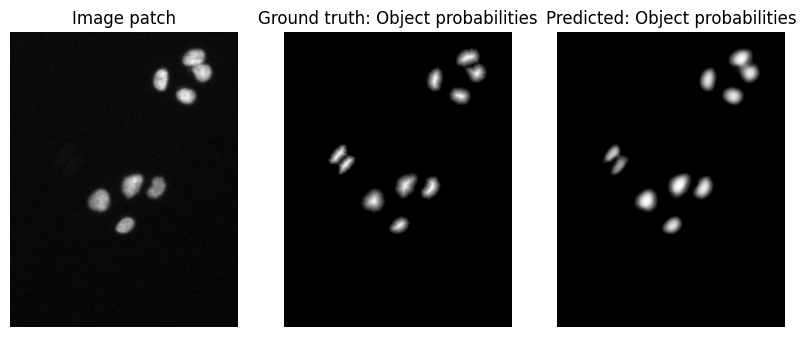

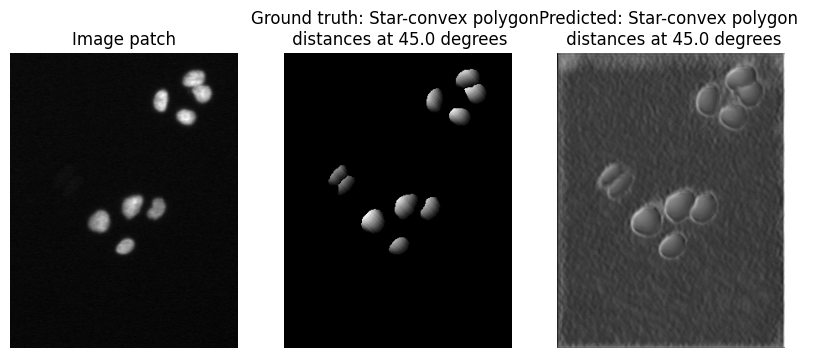

In [13]:
ort_session = onnxruntime.InferenceSession("onnx_model.onnx")
ort_inputs = {ort_session.get_inputs()[0].name: img_test}
mask_test_pred = ort_session.run(None, ort_inputs)

# rescale distances
mask_test_pred[0] = mask_test_pred[0] * max_val_dists

idx4 = 4

fig, ax = plt.subplots(1, 3, figsize=(10, 8))
img2, mask2 = ds_train[idx1]
ax[0].imshow(img_test[0, 0, :, :], cmap="gray")
ax[0].set_title("Image patch")
ax[1].imshow(mask_test[0, -1, :, :], cmap="gray")
ax[1].set_title("Ground truth: Object probabilities")
ax[2].imshow(mask_test_pred[1][0, 0, :, :], cmap="gray")
ax[2].set_title("Predicted: Object probabilities")
[axi.set_axis_off() for axi in ax.ravel()]
plt.show()

fig, ax = plt.subplots(1, 3, figsize=(10, 8))
img2, mask2 = ds_train[idx1]
ax[0].imshow(img_test[0, 0, :, :], cmap="gray")
ax[0].set_title("Image patch")
ax[1].imshow(mask_test[0, idx4, :, :], cmap="gray")
ax[1].set_title(f"Ground truth: Star-convex polygon \n distances at {idx2*360/N} degrees")
ax[2].imshow(mask_test_pred[0][0, idx4, :, :], cmap="gray")
ax[2].set_title(f"Predicted: Star-convex polygon \n distances at {idx2*360/N} degrees")
[axi.set_axis_off() for axi in ax.ravel()]
plt.show()

Great. The predict distances might seem a bit off for the background pixels, but remember that our custom loss does not penalize the mean absolute error for background pixels. Now we must convert our predicted StarDist masks to an instance segmentation mask. For that, we will use non-max suppression:

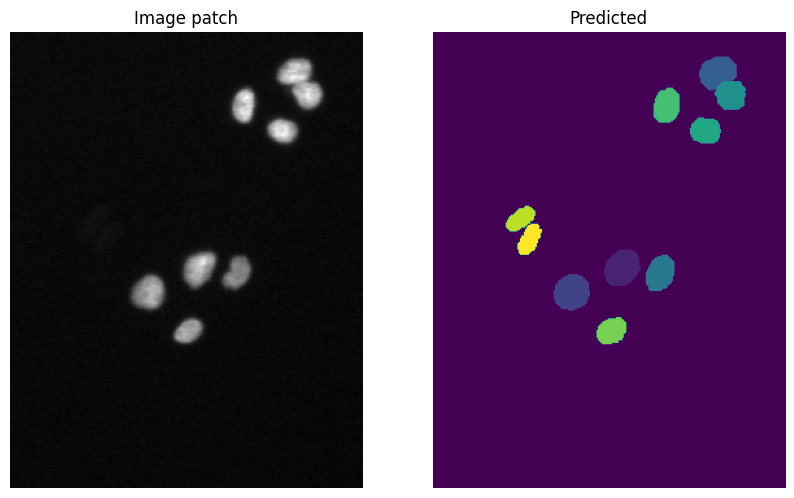

In [14]:
def create_instance_segmented_mask(
        prediction, prob_thresh=0.5, nms_threshold=0.4, dist_threshold=0):
    dists = np.moveaxis(prediction[0][0], 0, 2)
    probs = prediction[1][0, 0, :, :]
    N = dists.shape[2]
    
    # Select & order candidate pixels for non-max suppression
    probs_mask = (probs > prob_thresh)
    points = np.stack(np.where(probs_mask), axis=1)
    dists = dists[probs_mask]
    scores = probs[probs_mask]
    
    idx_sorted = np.argsort(scores)[::-1]
    dists = dists[idx_sorted]
    scores = scores[idx_sorted]
    points = points[idx_sorted]
    
    # Calculate coordinates of polygon candidates and calculate their area
    nms_mask = np.ones_like(scores, dtype=bool)
    dx = np.sin(2 * np.pi * np.arange(N) / N)
    dy = np.cos(2 * np.pi * np.arange(N) / N)  
    polygons = np.stack((
        np.round(np.tile(points[:, 0], (N, 1)).T + dists * dx).astype(np.int32), 
        np.round(np.tile(points[:, 1], (N, 1)).T + dists * dy).astype(np.int32)
        ), axis=2)
    areas = np.ones_like(scores)
    for idx0 in range(areas.shape[0]):
        areas[idx0] = -pyclipper.Area(polygons[idx0])
        
    # Non-max suppresion
    for idx1 in range(scores.shape[0]): 
        if nms_mask[idx1]:
            x1, y1 = points[idx1, :]
            
            for idx2 in range(idx1+1, scores.shape[0]):
                if nms_mask[idx2]:
                    x2, y2 = points[idx2, :]
                    dist_candidates = ((x2-x1)**2 + (y2-y1)**2)**0.5
                
                    if dist_candidates <= dist_threshold:
                        pc = pyclipper.Pyclipper()
                        pc.AddPath(polygons[idx1], pyclipper.PT_SUBJECT, True)
                        pc.AddPath(polygons[idx2], pyclipper.PT_CLIP, True)
                        points_intersection = pc.Execute(
                            pyclipper.CT_INTERSECTION, pyclipper.PFT_EVENODD, 
                            pyclipper.PFT_EVENODD)
                        if len(points_intersection) != 0:
                            area_intersection = pyclipper.Area(
                                points_intersection[0])
                            val = area_intersection / min(
                                areas[idx1], areas[idx2])
                            if val >= nms_threshold:
                                nms_mask[idx2] = False
                                
    # Prepare instance segmented mask
    out = np.zeros_like(probs)
    coords_all = np.array(np.meshgrid(
        np.arange(out.shape[0]), np.arange(out.shape[1]))).T.reshape(-1, 2)
    polygons = polygons[nms_mask]
    
    for idx3 in range(polygons.shape[0]):
        path = mlp_Path(polygons[idx3])
        mask = path.contains_points(coords_all, radius=1e-9) # radius argument to include the polygon line/border
        for (x, y) in coords_all[mask]: out[x, y] = idx3+1
    return out
        
        
nms_mask = create_instance_segmented_mask(
    mask_test_pred, prob_thresh=prob_thresh, nms_threshold=nms_threshold, 
    dist_threshold=100)

fig, ax = plt.subplots(1, 2, figsize=(10, 8))
img2, mask2 = ds_train[idx1]
ax[0].imshow(img_test[0, 0, :, :], cmap="gray")
ax[0].set_title("Image patch")
ax[1].imshow(nms_mask)
ax[1].set_title("Predicted")
[axi.set_axis_off() for axi in ax.ravel()]
plt.show()

Awesome!